In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, threshold=500)
pd.options.display.max_rows = 100
%matplotlib inline
import sys
sys.path.insert(0,'/usr/local/Cellar/opencv3/3.2.0/lib/python2.7/site-packages')
import cv2

In [2]:
dapeng_train = plt.imread("dapeng_train.png")
dapeng_train_mask = plt.imread("dapeng_train_mask.png")
dapeng_validation = plt.imread("dapeng_validation.png")
subimg_width, subimg_height = 160, 160

In [3]:
def mask_image():
    dapeng_train = cv2.imread('dapeng_train.png')
    dapeng_train_mask = cv2.imread('dapeng_train_mask.png')
    hsv = cv2.cvtColor(dapeng_train, cv2.COLOR_BGR2HSV)
    mask1 =cv2.inRange(hsv,np.array([10,40,140]),np.array([40,75,180]))
    mask2 = cv2.inRange(dapeng_train_mask,np.array([0,0,0]),np.array([254,254,254]))
    mask = cv2.bitwise_and(mask1,mask2)
    kernel = np.array([[0, 0, 0, 0, 0],
                       [0, 0, 0, 0, 0],
                       [2, 3, 4, 3, 2],
                       [0, 0, 0, 0, 0],
                       [0, 0, 0, 0, 0]], dtype=np.uint8)
    open = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    close = cv2.morphologyEx(open, cv2.MORPH_CLOSE, kernel)
    return close

def clip_into_peices(dapeng_image, dapeng_mask=None, horizontal_step=160, vertical_step=160, ):
    pieces_image = []
    labels = []
    for i in range(dapeng_image.shape[0]/horizontal_step):
        for j in range(dapeng_image.shape[1]/vertical_step):
            idx_1 = i*horizontal_step
            idx_2 = idx_1+horizontal_step
            idx_3 = j*vertical_step
            idx_4 = idx_3+vertical_step
            a = dapeng_image[idx_1:idx_2,idx_3:idx_4]
            pieces_image.append(a)
            if dapeng_mask is not None:
                if np.all(dapeng_mask[idx_1:idx_2,idx_3:idx_4]==0):
                    labels.append(0)
                else:
                    labels.append(1)
    return np.stack(pieces_image), np.array(labels)

In [4]:
data, labels = clip_into_peices(
    dapeng_train,
    mask_image(),
    subimg_width,
    subimg_height)
data.shape, labels.shape

((782, 160, 160, 3), (782,))

In [5]:
np.all(labels==0)

False

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

((695,), (87,))

# CNN二分类

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import keras


# nb_train_samples = train_index.shape[0]
# nb_validation_samples = test_index.shape[0]
epochs = 5
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, subimg_width, subimg_height)
else:
    input_shape = (subimg_width, subimg_height, 3)

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

keras.utils.vis_utils.plot_model(model, to_file="model.png")

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)

keras.utils.vis_utils.plot_model(model, to_file="model.png")

print('Test loss:', score[0])
print('Test accuracy:', score[1])

model_accuracy = score[1]

file_name = "dapeng_train_model_" + str(score[1])

model.save_weights("dapeng_train_model_{accuracy:.3f}.h5".format(accuracy=model_accuracy))

Train on 695 samples, validate on 87 samples
Epoch 1/5
695/695 [==============================] - 25s - loss: 0.7250 - acc: 0.5683 - val_loss: 0.6438 - val_acc: 0.7816

# 使用训练好的模型分类

In [8]:
validation_data, _ = clip_into_peices(
    dapeng_validation,
    None,
    subimg_width,
    subimg_height)
validation_data.shape

(1550, 160, 160, 3)

In [9]:
validation_labels = model.predict_classes(validation_data)
validation_labels.shape

1550/1550 [==============================] - 17s     

(1550, 1)

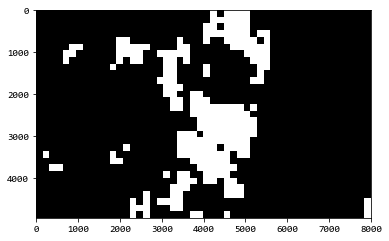

In [10]:
num_of_row, num_of_col = dapeng_validation.shape[0]/subimg_width, dapeng_validation.shape[1]/subimg_height
shaped_labels = validation_labels.reshape(num_of_row, num_of_col, 1)
image_mask = []
for i in range(num_of_row):
    row_mask = []
    for j in range(num_of_col):
        if shaped_labels[i][j]:
            mask = np.ones(subimg_width*subimg_height).reshape(subimg_width, subimg_height)
        else:
            mask = np.zeros(subimg_width*subimg_height).reshape(subimg_width, subimg_height)
        row_mask.append(mask)
    image_mask.append(np.hstack(row_mask))
    
mask_final = np.vstack(image_mask)
np.save("mask_final", mask_final)

plt.imshow(mask_final, cmap='gray')

In [11]:
mask_final.shape

(4960, 8000)

In [12]:
mask_final = mask_final.astype(np.uint8)
mask_final.shape

(4960, 8000)

In [13]:
cv_dapeng_validation = cv2.imread("dapeng_validation.png")
cv_dapeng_validation.shape

(5001, 8075, 3)

In [14]:
mask_final.dtype = np.uint8
m = cv2.inRange(mask_final,np.array([1]),np.array([255]))
m.shape

(4960, 8000)

In [15]:
cv_dapeng_validation = cv2.imread("dapeng_validation.png")
cv_dapeng_validation = cv_dapeng_validation[:mask_final.shape[0],:mask_final.shape[1]]
mm = cv2.bitwise_and(cv_dapeng_validation, cv_dapeng_validation, mask=mask_final)

In [16]:
cv2.imwrite("dapeng_result_{accuracy:.3f}.png".format(accuracy=model_accuracy), mm)

True